In [1]:
import pandas as pd
import re
import os
import sys
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from mice_inspection_utils import *


imput_subj_paths = [f"Data/raw/total.full.rn.RA.total_OTU_table.mouse{i+1}.ovr0.0p.csv" for i in range(0, 8)]
output_subj_paths = [f"Data/by_mouse/mouse_{i+1}.csv" for i in range(0, 8)]
metadata_path = "Data/raw/OTU_table.csv"
mi = Mice_Inspection(ip = imput_subj_paths, op = output_subj_paths, mdp = metadata_path)

/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_3904/3874384173.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/miriamzara/LCPA_project/mice_inspection_utils.py:984: SyntaxWarning: invalid escape sequence '\L'
  with PdfPages(f"Inspection_Outputs\LMfits\Mouse_{mouse_num+1}_LM_Fits.pdf") as pdf:
/Users/miriamzara/LCPA_project/mice_inspection_utils.py:1066: SyntaxWarning: invalid escape sequence '\L'
  print('PDF files already exist in Inspection_Outputs\LMfits. Delete directory Inspection_Outputs\LMfits to regenerate plots.')


In [4]:
directory = "new_outputs_miriam"
os.makedirs(directory, exist_ok = True)

### How reliable is our data

OTUs come with a % confidence score on the species assignation. Every read will map to a different OTU, this is why there are more OTUs than species.
We would like to discard OTUs that have a low confidence on the species. But how 
The unique identifier of an OTU is the SEQUENCE ??


% id,alignment length,mismatches,gap openings,e-value,bit score,coverage,sequence


Let's see how many samples have a confidence level > ( 1 - threshold ), for threshold values ranging in [0, 1]. 

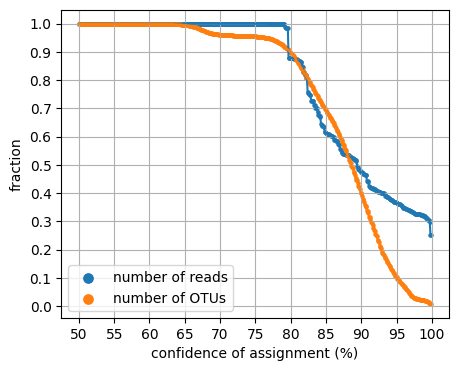

In [5]:
metadata_df = pd.read_csv(metadata_path)
df = metadata_df[["query", "total_reads", "% id"]]
df.head()
total_ = df["total_reads"].sum()
total_otus = len(df)

thresholds = np.arange(50, 100, 0.1)
reads_fraction = np.zeros(len(thresholds))
otus_fraction = np.zeros(len(thresholds))

for i, t in enumerate(thresholds):
    reads_fraction[i] = df[df["% id"] > t]["total_reads"].sum() / total_
    otus_fraction[i] = len(df[df["% id"] > t]["total_reads"]) / total_otus


fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,4))
ax.scatter(thresholds, reads_fraction, s = 5, label = "number of reads")
ax.plot(thresholds, reads_fraction)
ax.grid(which = "both")
ax.set_xlabel("confidence of assignment (%)")
ax.set_ylabel("fraction")
ax.set_xticks(np.arange(50, 101, 5))
ax.set_yticks(np.arange(0, 1.1, 0.1))
#ax.set_xticklabels(np.arange(0, 1.1, 0.1))

ax.scatter(thresholds, otus_fraction, s = 5, label = "number of OTUs")
ax.plot(thresholds, otus_fraction)
ax.legend(markerscale = 3)

output_path = os.path.join(directory, "assignment_confidence.png")
plt.savefig(output_path, dpi = 600)

Comments: clearly we should forget about the typical confidence levels used in physics. With a Cl of 95%, for instance, we would discard over 60% of the reads!

A reasonable choice could be a CL 0f 80%... Still, pretty low for a physicist's standard. We should keep in mind for all subsequent analysis that this is the data we work with.

#### Looking at time series: testing the null hypotesis of stationarity.



Before going on with the stochastic logistic model, we should - at least -  test the null hypotesis of stationarity. Two main tests can be used:

- The augmented dickey-fuller (ADF) test: models the time series as an autoregressive model of order p-th and checks if its is stationary by analyzing the roots of the poli

- KPSS test: decomposes as moving average plus white noise. checks if this moving average is constant.

### Analyis of correlograms (the sample ACF)

In a stationary process, we expect ACF(k) to eventually settle to zero as the lag k increases - either abruptly, or in an oscillating fashion, or exponentially like, or with some other trend, depending on the underlying process.

When looking at correlograms, we can already perform a statistic test on the null hypotesis that the series is **pure white noise**. Individual sample autocorrelations would be approximately distributed with mean zero and variance 1/T under the hypotesis that the series is white noise.



**Definition** Autocorrelation Function (ACF) of a time series ${x_t}$

$$
ACF(k, t) = \frac{Cov(x_t, x_{t-k})}{Cov(x_t, x_t)}
$$

For a *stationary* time series, ACF depends only on the lag $k$, not on the absolute time $t$. It becomes:

$$
ACF(k) = \frac{Cov(x_t, x_{t-k})}{Cov(x_0, x_0)} = \frac{Cov(x_t, x_{t-k})}{Var(x_0)}
$$


However, we have a finite time series, of length T, therefore we will *estimate* the ACF, but not know it exactly. Our sample estimate is:


$$
\tilde{ACF}(k) = \frac{\frac{1}{N-k-1} \sum_{t = K + 1}^T (x_t - \overline{x})\cdot(x_{t-k} - \overline{x})}{\frac{1}{N-1} \sum_{t=1}^T (x_t - \overline{x})^2} 
$$

where $\overline{x}= \frac{1}{T} \sum_{t=1}^T x_t$ is the sample mean.

We need to associate an error on ACF(k). The error we associate will depends on our underlying assumption on the time series. 

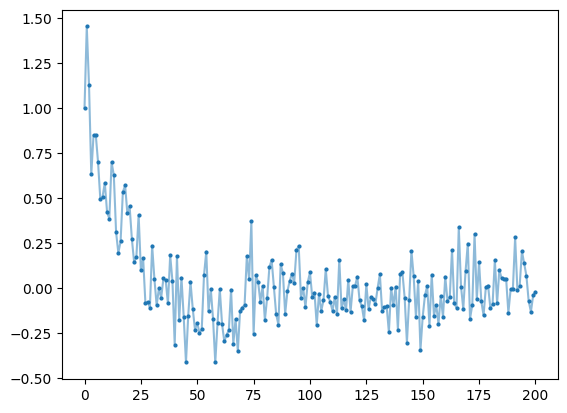

In [6]:
from statsmodels.tsa.stattools import acf


df = pd.read_csv("Data/by_mouse_transposed/mouse_1_transposed.csv")
times = df["day"].to_numpy(dtype=int)
counts = df["Prevotella sp. Smarlab 121567"].copy()#.to_numpy(dtype=int)

lag_max = 200
acf_ = acf(x = counts, nlags = lag_max, qstat = False, adjusted = True, missing = "conservative")

plt.plot(np.arange(0, lag_max + 1), acf_, alpha = 0.5)
plt.scatter(np.arange(0, lag_max + 1), acf_, s = 4)


In [7]:
from scipy.stats import chi2


# Anatomy of stattools.acovf
# Super nice code! 
# My own attempt was a mess with respect to this
# A reminder to always use pre-built functions when available!

#x = np.array([1, np.nan, 2, 3,5,6,np.nan])


def acf_with_missing(y, return_ljung_box = False):

    x = y.copy()
    n = len(x)
    notmask_bool = ~np.isnan(x)  # bool
    notmask_int = notmask_bool.astype(int) # zeros for nan
    # Must copy for thread safety
    x[~notmask_bool] = 0
    #print(x)
    #print(notmask_int)
    xo = x - x.sum() / notmask_int.sum()
    xo[~notmask_bool] = 0
    #print(xo)

    
    # compute number of valid pairs
    d = np.correlate(notmask_int, notmask_int, "full")
    #print("lags:", np.arange(0, len(d)) - (n-1))
    #print(d)
    # only consider positive lags:
    #print("lags:", np.arange(n-1, len(d))- (n-1))
    #print(d[n-1 :])
    valid_pairs = d[n - 1 :] != 0
    d[d == 0] = 1
    acov = np.correlate(xo, xo, "full")[n - 1 :] / d[n - 1 :]
    acov[~valid_pairs] = np.nan
    #print(acov)
    # White noise errors
    white_errors = 1/ np.sqrt(d[n-1 :])
    white_errors[~valid_pairs] = np.nan
    acf = acov/acov[0]
    if return_ljung_box == False:
        return acf, white_errors
    else:
    # Ljung box statistics
        ret = (
            n
            * (n + 2)
            * np.cumsum((1.0 / d[n - 1 :]) * acf ** 2)
        )
        chi2_ = chi2.sf(x = ret, df = np.arange(1, n+1))
        return acf, white_errors, ret, chi2_

#acov = acf_with_missing(x)
x = counts.to_numpy()
lag_max = len(x)

acf_mine, white_errors = acf_with_missing(x)

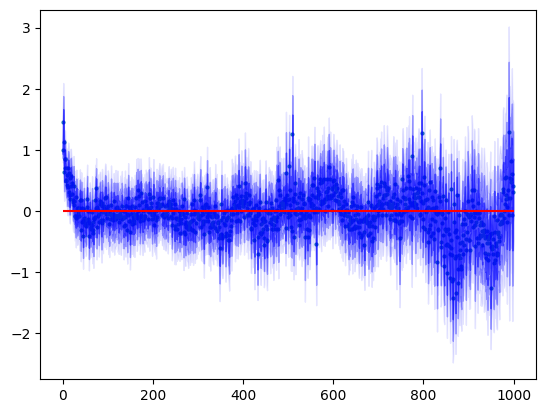

In [8]:
x = counts.to_numpy()
lag_max = len(x)

acf_mine, white_errors = acf_with_missing(x)


acf_ = acf(x, nlags= lag_max, adjusted = True, missing = "conservative")



lag_max_plot = 1000
#plt.plot(np.arange(0, lag_max_plot), acf_mine[0:lag_max_plot], color = "blue", linewidth = 0.1, alpha = 1,label = "mine")
plt.scatter(np.arange(0, lag_max_plot), acf_mine[0: lag_max_plot], s = 4)
plt.fill_between(x = np.arange(0, lag_max_plot), y1 =acf_mine[0: lag_max_plot] - white_errors[0:lag_max_plot], y2 =acf_mine[0: lag_max_plot] + white_errors[0:lag_max_plot], color = "blue", alpha = 0.5 )
plt.fill_between(x = np.arange(0, lag_max_plot), y1 =acf_mine[0: lag_max_plot] - 2* white_errors[0:lag_max_plot], y2 =acf_mine[0: lag_max_plot] + 2*white_errors[0:lag_max_plot], color = "blue", alpha = 0.3 )
plt.fill_between(x = np.arange(0, lag_max_plot), y1 =acf_mine[0: lag_max_plot] - 3* white_errors[0:lag_max_plot], y2 =acf_mine[0: lag_max_plot] + 3*white_errors[0:lag_max_plot], color = "blue", alpha = 0.1 )
plt.hlines( y= 0, xmin = 0, xmax = lag_max_plot, color = "red")
#plt.plot(np.arange(0, lag_max_plot), acf_[0: lag_max_plot], alpha = 0.5, label = "library")
#plt.scatter(np.arange(0, lag_max_plot), acf_[0: lag_max_plot], s = 4)
#plt.legend()

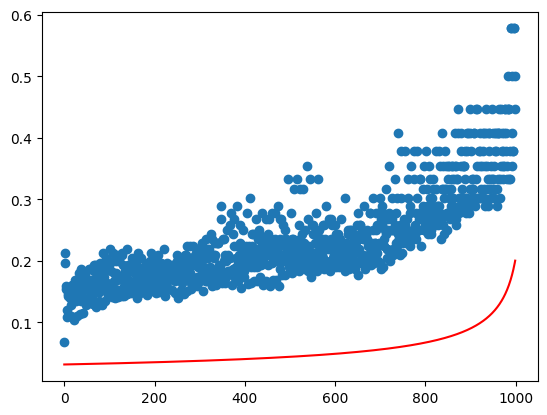

In [79]:
lag_max_plot = 1000
plt.scatter(np.arange(0, lag_max_plot), white_errors[0: lag_max_plot])

# expected without missing data
x = np.arange(0, lag_max_plot)
N = 1024
plt.plot(x, 1/np.sqrt(N - x), color = "red")

#### White noise test

Liung - Box q statistics

$Q = T\cdot (T+2)  \sum_{k=1}^p \, \frac{r_k^2}{T-k}$

$Q \rightarrow \Chi^2$ with $p$ degrees of freedom in the infinite sample limit


How to choose p (the maximum number of lags)? 

Depends on the time series length. It should not be too small, but also not too large because for large p the estimate of ACF(p) becomes too noisy.

In [60]:
from statsmodels.tsa.stattools import q_stat

lags_list = 100

ret, chi2 = q_stat(x = acf_mine, nobs = 1024)



for i, lag in enumerate(ret):
    print(f"lag: {lag} chi2: {chi2[i]}")
#print(chi2) # sf(x, df) survival function (1- cdf(x, df)) df = degrees of freedom

lag: 1027.0029325513196 chi2: 2.4259347512950435e-225
lag: 3198.6229190738172 chi2: 0.0
lag: 4503.2287050749865 chi2: 0.0
lag: 4913.928656595698 chi2: 0.0
lag: 5658.463521206025 chi2: 0.0
lag: 6403.978300476457 chi2: 0.0
lag: 6908.963370495463 chi2: 0.0
lag: 7161.657265733235 chi2: 0.0
lag: 7427.865201193435 chi2: 0.0
lag: 7781.565076002093 chi2: 0.0
lag: 7966.035007584263 chi2: 0.0
lag: 8119.6343032940395 chi2: 0.0
lag: 8628.217194887635 chi2: 0.0
lag: 9036.510063993348 chi2: 0.0
lag: 9136.590305118478 chi2: 0.0
lag: 9176.29362013858 chi2: 0.0
lag: 9245.783956171614 chi2: 0.0
lag: 9541.906452985573 chi2: 0.0
lag: 9882.212232945125 chi2: 0.0
lag: 10062.247908823188 chi2: 0.0
lag: 10278.969584172168 chi2: 0.0
lag: 10357.087223858909 chi2: 0.0
lag: 10378.649540717535 chi2: 0.0
lag: 10409.67375680027 chi2: 0.0
lag: 10583.048974518817 chi2: 0.0
lag: 10593.111253436802 chi2: 0.0
lag: 10621.67858307411 chi2: 0.0
lag: 10628.908647466975 chi2: 0.0
lag: 10635.274602783133 chi2: 0.0
lag: 10647.9

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:570: RuntimeWarning: divide by zero encountered in divide
  * np.cumsum((1.0 / (nobs - np.arange(1, len(x) + 1))) * x ** 2)


lags: [0 1 2 3 4 5 6 7 8]
[6 3 3 3 2 2 1 0 1]


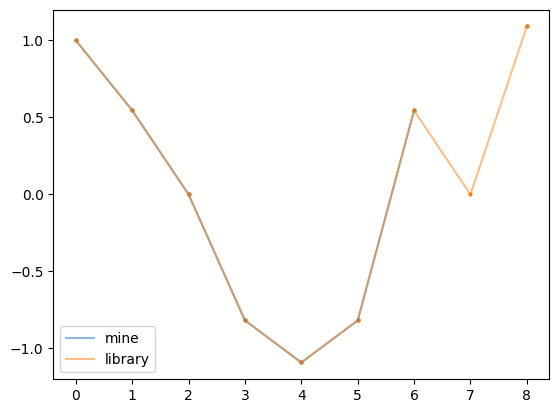

In [8]:
x = np.array([1, np.nan, 2, 3,5,6,np.nan, np.nan, 1])
#x = counts.to_numpy()
lag_max = len(x)

acov = acf_with_missing(x)


acf_ = acf(x, nlags= lag_max, adjusted = True, missing = "conservative")


lag_max_plot = min(lag_max, 10)
plt.plot(np.arange(0, lag_max_plot), acov[0:lag_max_plot]/acov[0], alpha = 0.5,label = "mine")
plt.scatter(np.arange(0, lag_max_plot), acov[0: lag_max_plot]/acov[0], s = 4)
plt.plot(np.arange(0, lag_max_plot), acf_[0: lag_max_plot], alpha = 0.5, label = "library")
plt.scatter(np.arange(0, lag_max_plot), acf_[0: lag_max_plot], s = 4)
plt.legend()

lags: [   0    1    2 ... 1041 1042 1043]
[217  22  26 ...   0   0   1]


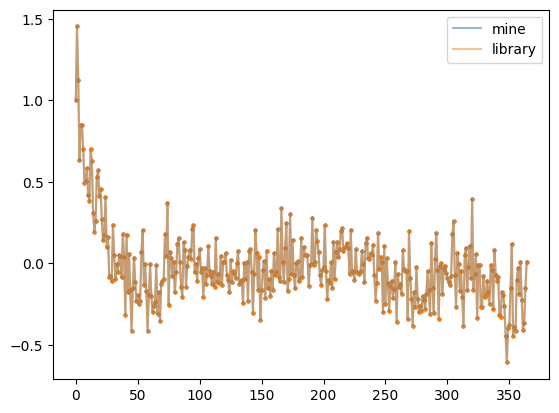

In [9]:
#x = np.array([1, np.nan, 2, 3,5,6,np.nan, np.nan, 1])
x = counts.to_numpy()
lag_max = len(x)

acov = acf_with_missing(x)


acf_ = acf(x, nlags= lag_max, adjusted = True, missing = "conservative")


lag_max_plot = 365
plt.plot(np.arange(0, lag_max_plot), acov[0:lag_max_plot]/acov[0], alpha = 0.5,label = "mine")
plt.scatter(np.arange(0, lag_max_plot), acov[0: lag_max_plot]/acov[0], s = 4)
plt.plot(np.arange(0, lag_max_plot), acf_[0: lag_max_plot], alpha = 0.5, label = "library")
plt.scatter(np.arange(0, lag_max_plot), acf_[0: lag_max_plot], s = 4)
plt.legend()


Riassunto: la funzione pre-built di statstools fa quello che deve, con l'unico difetto che però non distingue nell output finale le correlazioni che sono 0. perchè non c'erano coppie valide su cui calcolarle (e che quindi dovrebbero essere dei nan a rigore) dagli zeri "reali".

Ora devo stimare gli errori e capire cos'è il test di Lijung-Box per l'ipotesi nulla di white noise.



Rispetto agli errori, leggo da statsmodels:


bartlett_confint : bool, default True
Confidence intervals for ACF values are generally placed at 2 standard errors around r_k. The formula used for standard error depends upon the situation. If the autocorrelations are being used to test for randomness of residuals as part of the ARIMA routine, the standard errors are determined assuming the residuals are white noise. The approximate formula for any lag is that standard error of each r_k = 1/sqrt(N). See section 9.4 of [2] for more details on the 1/sqrt(N) result. For more elementary discussion, see section 5.3.2 in [3]. For the ACF of raw data, the standard error at a lag k is found as if the right model was an MA(k-1). This allows the possible interpretation that if all autocorrelations past a certain lag are within the limits, the model might be an MA of order defined by the last significant autocorrelation. In this case, a moving average model is assumed for the data and the standard errors for the confidence intervals should be generated using Bartlett's formula. For more details on Bartlett formula result, see section 7.2 in [2]

#### ACF for all species

In [ ]:
df = pd.read_csv("Data/by_mouse_transposed/mouse_1_transposed.csv")
times = df["day"].to_numpy(dtype=int)


acf_list = []
errors_list = []
names_list = []

for ncol in np.arange(1, 11):
    name = df.columns[ncol]
    counts = df[f"{name}"].copy()#.to_numpy(dtype=int)
    x = counts.to_numpy()
    lag_max = len(x)
    acf_mine, white_errors = acf_with_missing(x)
    acf_list.append(acf_mine)
    errors_list.append(white_errors)
    names_list.append(name)

NameError: name 'acf_with_missing' is not defined

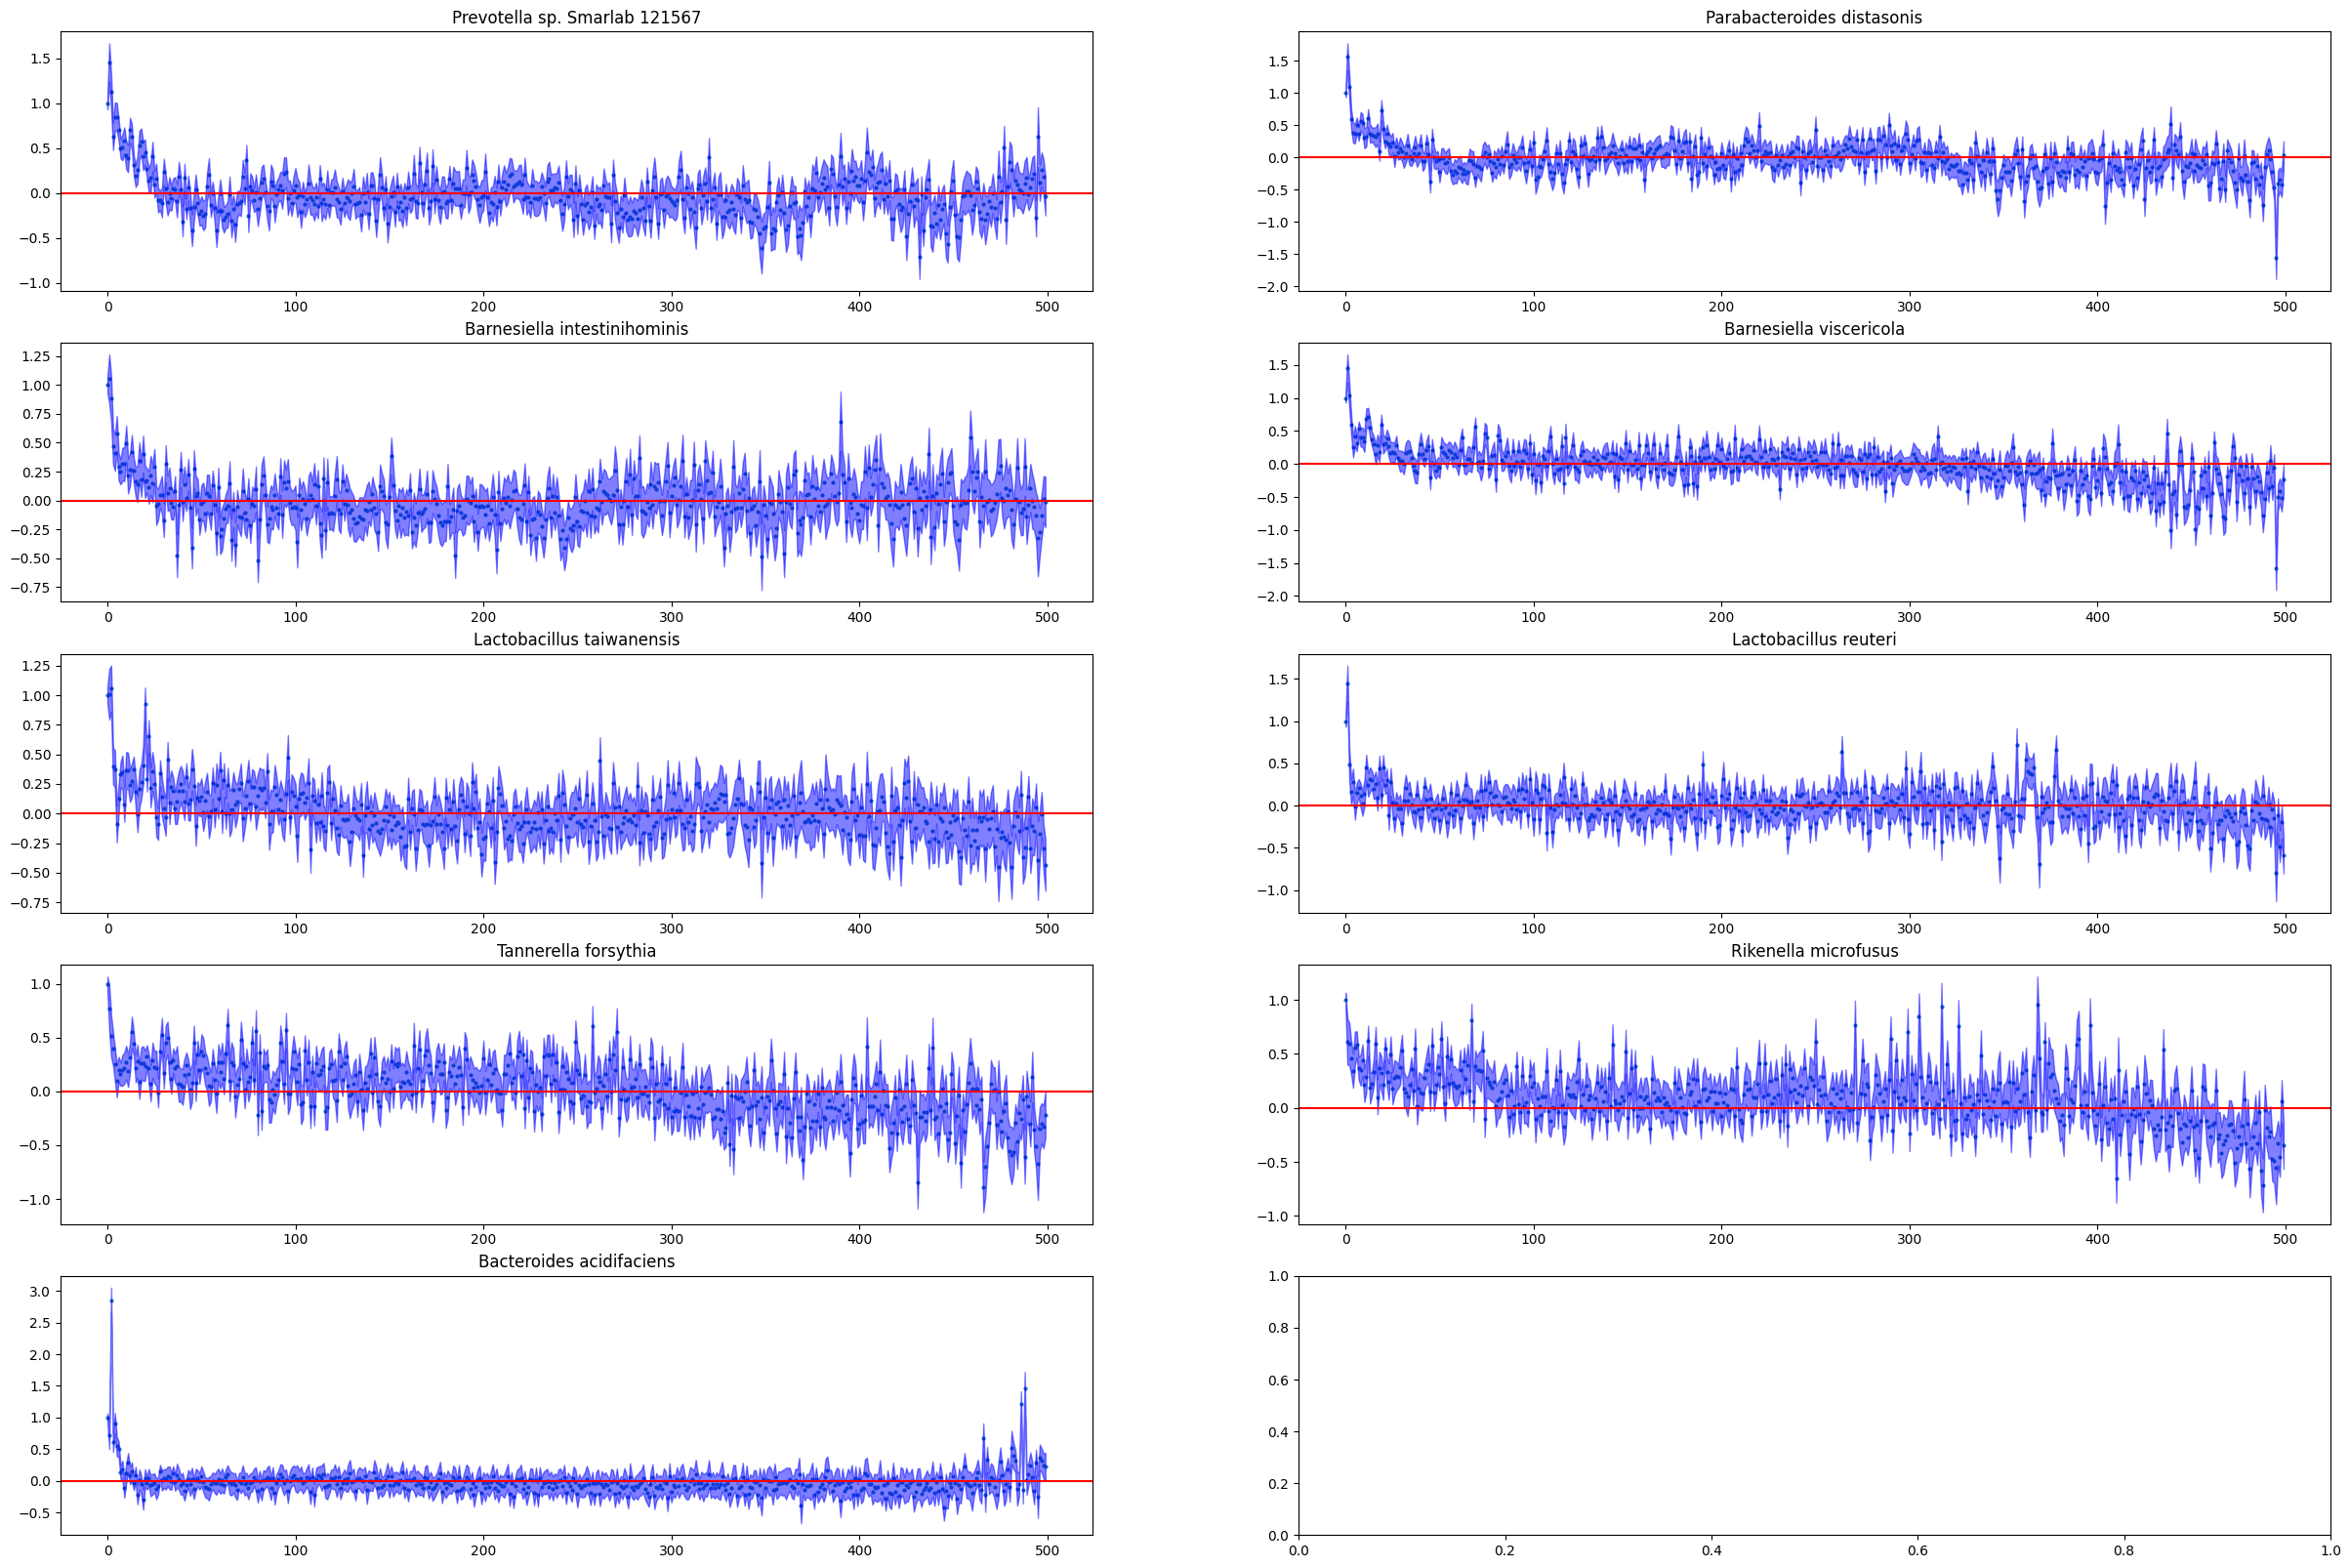

In [100]:
lag_max_plot = 500

fig, axs =plt.subplots(nrows = 5, ncols = 2, figsize = (30, 20))

axs = axs.flatten()
for i in np.arange(0, 9):
    ax = axs[i]
    acf_mine = acf_list[i]
    white_errors = errors_list[i]
    name = names_list[i]
    ax.scatter(np.arange(0, lag_max_plot), acf_mine[0: lag_max_plot], s = 4)
    ax.fill_between(x = np.arange(0, lag_max_plot), y1 =acf_mine[0: lag_max_plot] - white_errors[0:lag_max_plot], y2 =acf_mine[0: lag_max_plot] + white_errors[0:lag_max_plot], color = "blue", alpha = 0.5 )
    #ax.fill_between(x = np.arange(0, lag_max_plot), y1 =acf_mine[0: lag_max_plot] - 2* white_errors[0:lag_max_plot], y2 =acf_mine[0: lag_max_plot] + 2*white_errors[0:lag_max_plot], color = "blue", alpha = 0.3 )
    #ax.fill_between(x = np.arange(0, lag_max_plot), y1 =acf_mine[0: lag_max_plot] - 3* white_errors[0:lag_max_plot], y2 =acf_mine[0: lag_max_plot] + 3*white_errors[0:lag_max_plot], color = "blue", alpha = 0.1 )
    ax.axhline( y= 0, xmin = 0, xmax = lag_max_plot, color = "red")
    ax.set_title(f"{name}")

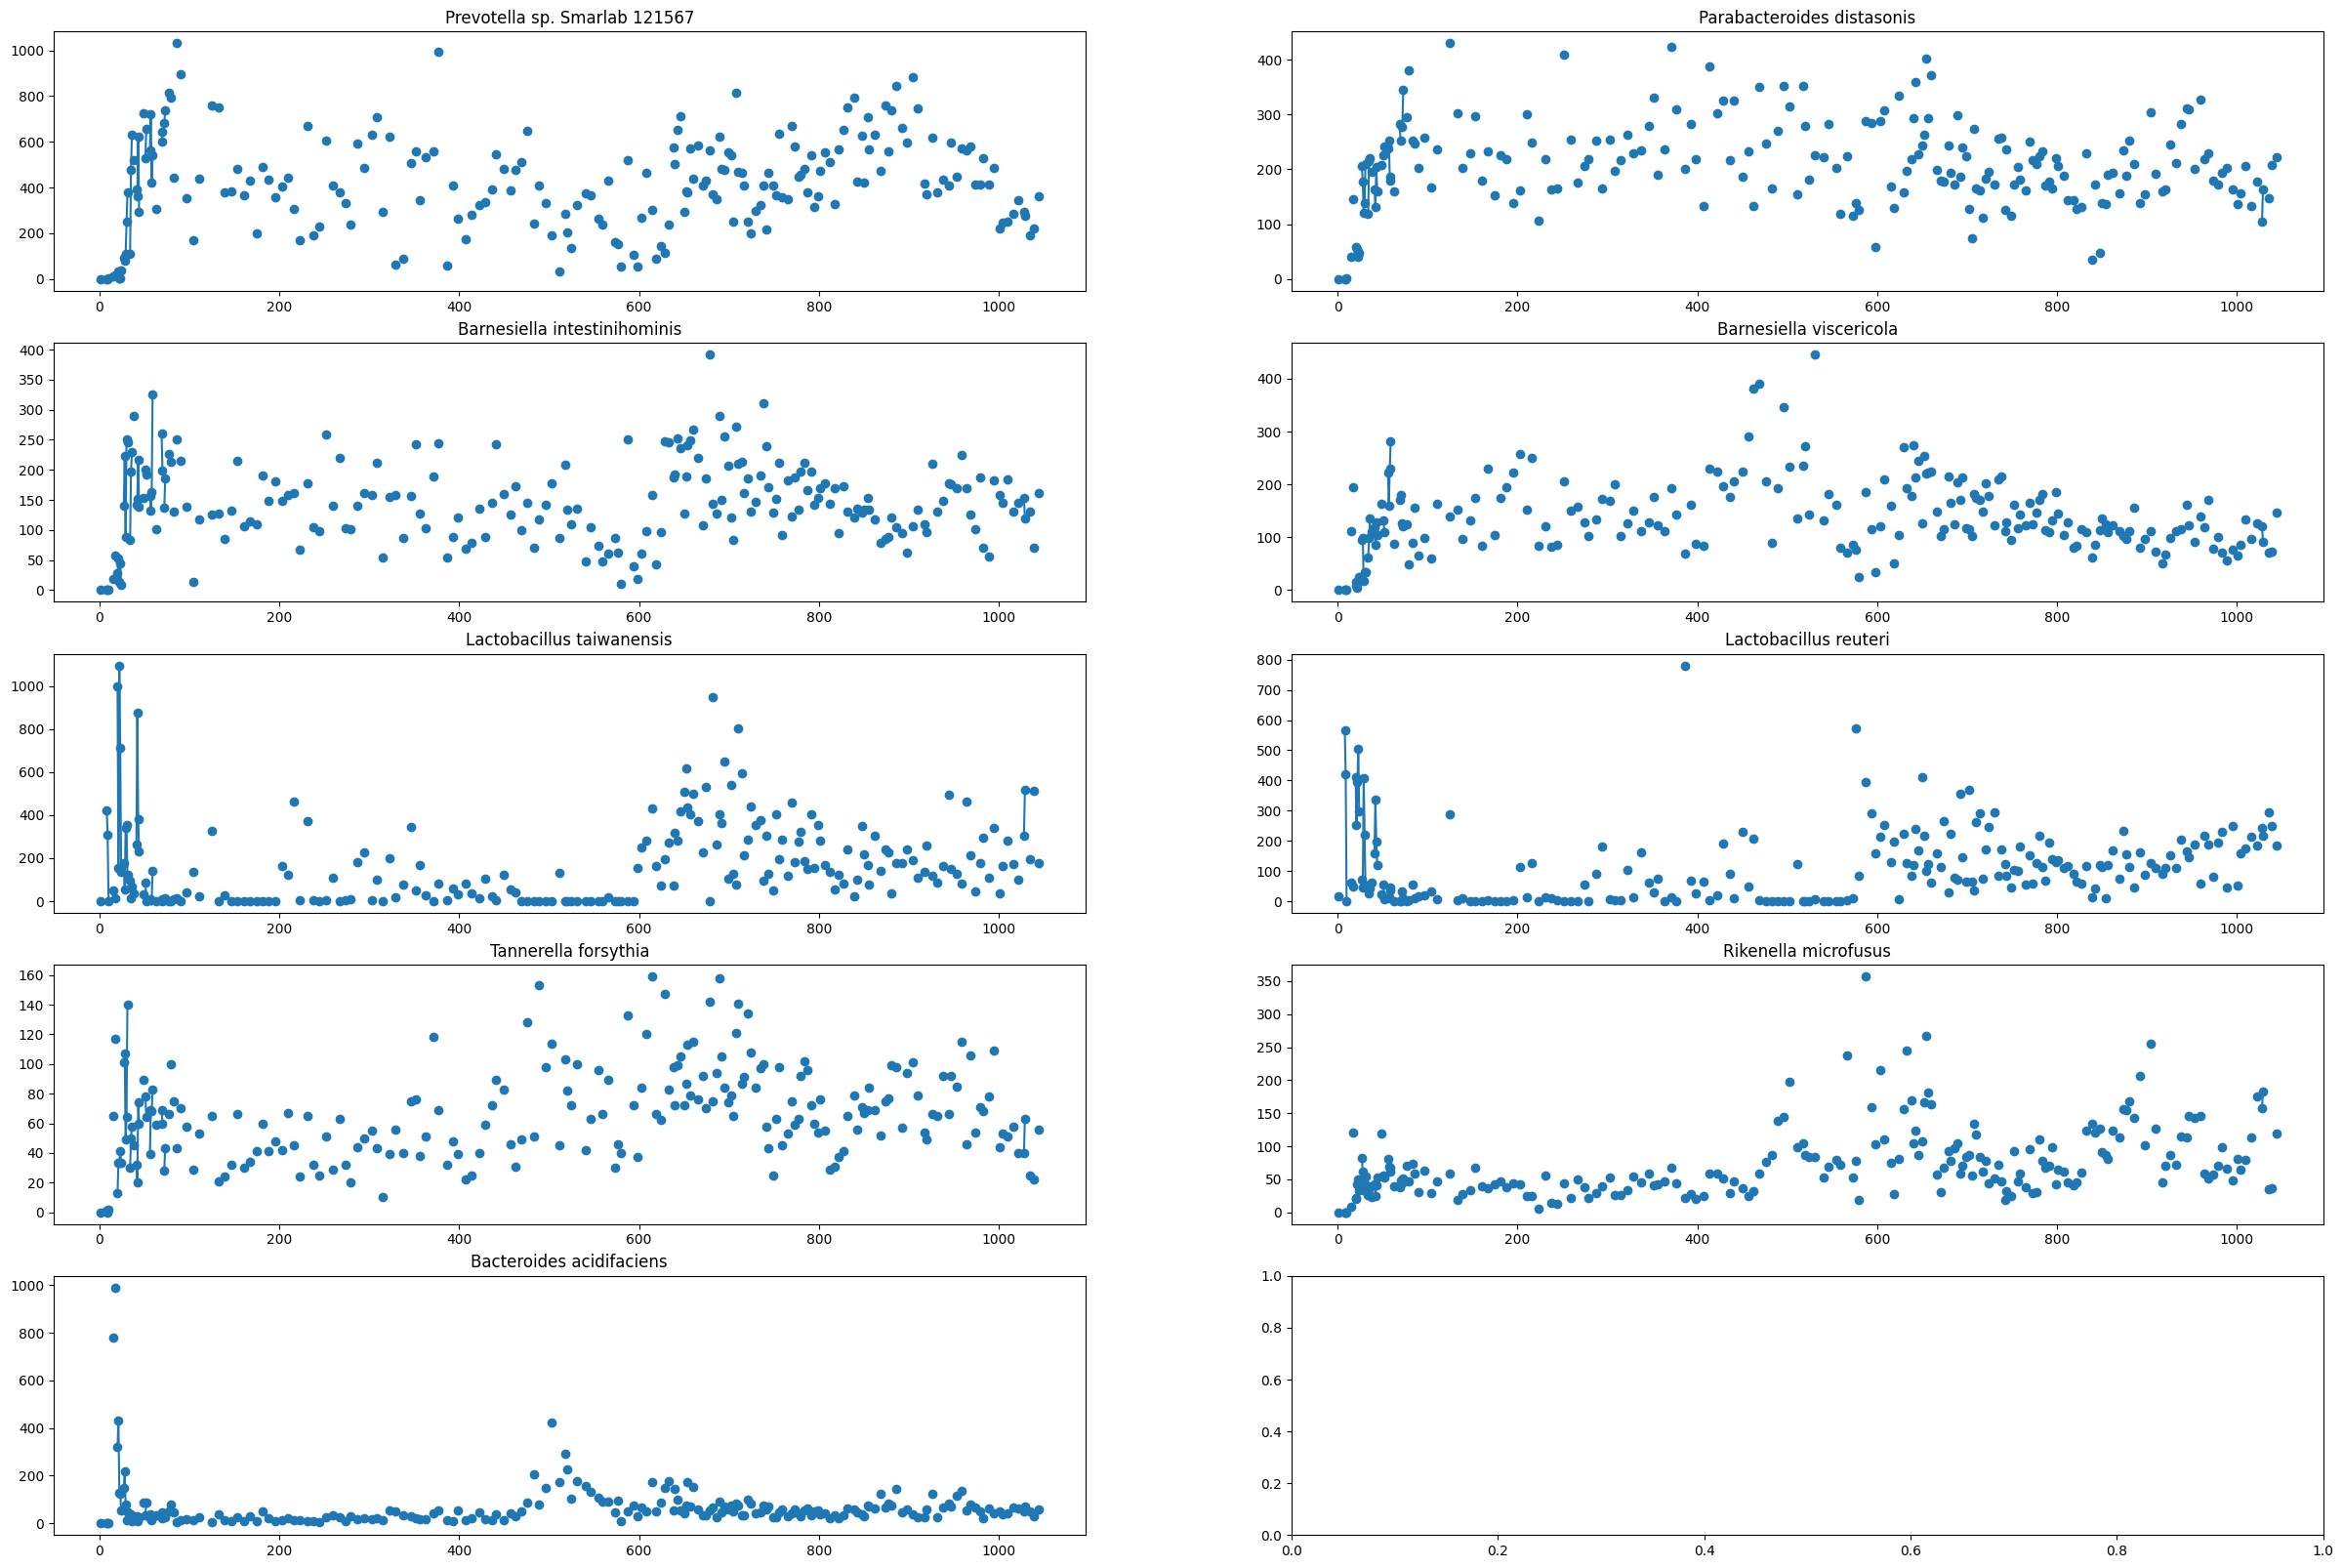

In [97]:
fig, axs =plt.subplots(nrows = 5, ncols = 2, figsize = (30, 20))

axs = axs.flatten()
for i in np.arange(0, 9):
    ax = axs[i]
    counts = df.iloc[:, i+1].copy()
    ax.scatter(times, counts)
    ax.plot(times, counts)
    ax.set_title(names_list[i])

### Genus - aggregated analysis


Let's test pairwise correlations. Are intra-genus correlations significantly higher than inter-genus correlations?

In [2]:
metadata_df = mi.metadata_df
#metadata_df
unique_combos = metadata_df[['Genus', 'Species']].drop_duplicates()
mapping = dict(zip(unique_combos['Species'], unique_combos['Genus']))
np.unique(mapping.values())




array([dict_values(['Prevotella', 'Lactobacillus', 'Parabacteroides', 'Lactobacillus', 'Lactobacillus', 'Bacteroides', 'Lactobacillus', 'Allobaculum', 'Barnesiella', 'Lactobacillus', 'Prevotella', 'Prevotella', 'Streptococcus', 'Barnesiella', 'Eubacterium', 'Candidatus Arthromitus', 'Rikenella', 'Coprobacter', 'Tannerella', 'Bacteroides', 'Nubsella', 'Prevotella', 'Tannerella', 'Alistipes', 'Paraprevotella', 'Aureibacter', 'Bacteroides', 'Prevotella', 'Prevotella', 'Clostridium', 'Parasutterella', 'Bifidobacterium', 'Vibrio', 'Prevotella', 'Streptococcus', 'Lactococcus', 'Clostridium', 'Clostridium', 'Odoribacter', 'Eubacterium', 'Peptococcus', 'Staphylococcus', 'Clostridium', 'Coprobacillus', 'Clostridium', 'Alistipes', 'Clostridium', 'Pseudoflavonifractor', 'Clostridium', 'Clostridium', 'Roseburia', 'Clostridium', 'Eubacterium', 'Ruminococcus', 'Clostridium', 'Eubacterium', 'Gordonibacter', 'Turicibacter', 'Clostridium', 'Akkermansia', 'Clostridium', 'Dorea', 'Desulfovibrio', 'Prevot

a test for a single genus

Prevotella 8 Prevotella 8
[[ 1.          0.35328069  0.2420124   0.31887048  0.35278696  0.28383341
   0.26883945  0.52557686]
 [ 0.35328069  1.          0.07919255  0.31172952  0.97105955  0.46074665
   0.10523427  0.42360214]
 [ 0.2420124   0.07919255  1.          0.28219536  0.08298746 -0.03867342
   0.3137406   0.14531264]
 [ 0.31887048  0.31172952  0.28219536  1.          0.3027438   0.07965979
   0.26690545  0.33682844]
 [ 0.35278696  0.97105955  0.08298746  0.3027438   1.          0.45639337
   0.09428059  0.4366849 ]
 [ 0.28383341  0.46074665 -0.03867342  0.07965979  0.45639337  1.
   0.22533591  0.32877792]
 [ 0.26883945  0.10523427  0.3137406   0.26690545  0.09428059  0.22533591
   1.          0.12854491]
 [ 0.52557686  0.42360214  0.14531264  0.33682844  0.4366849   0.32877792
   0.12854491  1.        ]]
Mean correlation for genus Prevotella=  0.3793275828754558


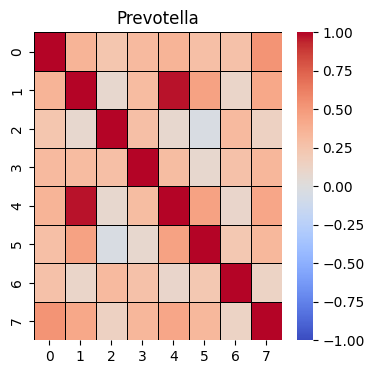

Lactobacillus 3 Lactobacillus 3
[[ 1.          0.58623374 -0.04539404]
 [ 0.58623374  1.          0.21238185]
 [-0.04539404  0.21238185  1.        ]]
Mean correlation for genus Lactobacillus=  0.5007158985099439


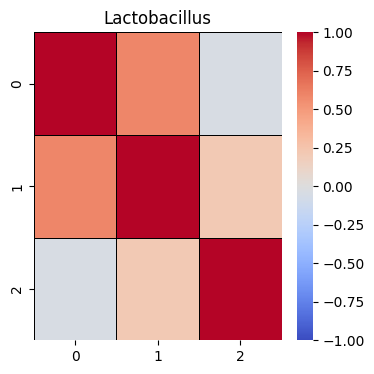

Eubacterium 4 Eubacterium 4
[[ 1.00000000e+00  5.58153834e-03  2.12932224e-01 -1.22574216e-01]
 [ 5.58153834e-03  1.00000000e+00 -7.52946698e-02  3.17552692e-02]
 [ 2.12932224e-01 -7.52946698e-02  1.00000000e+00  6.47224288e-04]
 [-1.22574216e-01  3.17552692e-02  6.47224288e-04  1.00000000e+00]]
Mean correlation for genus Eubacterium=  0.25663092120147646


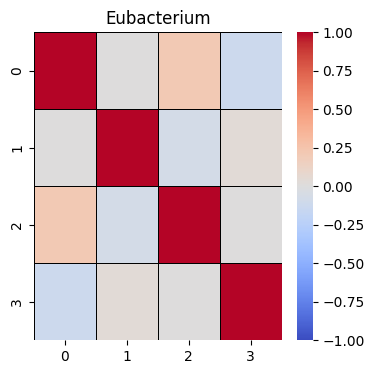

In [5]:
genus = "Prevotella"

df = pd.read_csv("Data/by_mouse_transposed/mouse_1_transposed.csv")
species = df.columns[1:]

def species_list(genus):
    bool_mask = [(mapping[f'{species_}']== f"{genus}" and (df[f'{species_}'].median() > 1) ) for species_ in species]
    filtered_species = species[bool_mask].to_list()
    num_species = len(filtered_species)
    return filtered_species, num_species


def genus_corr(genus_a, genus_b):
    filtered_species_a, num_species_a = species_list(genus_a)
    filtered_species_b, num_species_b = species_list(genus_b)
    print(genus_a, num_species_a, genus_b, num_species_b)
    if num_species_a < 1 or num_species_b <1:
        estimated_pearson = None
        return
    estimated_covariance = np.zeros(shape = (num_species_a, num_species_b))
    estimated_pearson = np.zeros(shape = (num_species_a, num_species_b))

    for i, s_a in enumerate(filtered_species_a):
        for j, s_b in enumerate(filtered_species_b):
            a = df[f"{s_a}"]
            b = df[f"{s_b}"]
            mask = ~np.isnan(a) & ~np.isnan(b)
            if np.sum(mask) > 1:
                estimated_covariance[i, j] = np.cov(a[mask], b[mask])[0, 1]
            else:
                estimated_covariance[i, j] = np.nan
            #estimated_covariance[i, j] = np.cov(a[mask], b[mask])[0, 1]

    for i, s_a in enumerate(filtered_species_a):
        for j, s_b in enumerate(filtered_species_b):
            a = df[f"{s_a}"]
            b = df[f"{s_b}"]
            mask = ~np.isnan(a) & ~np.isnan(b)
            if np.sum(mask) > 1:
                denom = np.sqrt(a[mask].var() * b[mask].var())
            else:
                denom = 0
            if denom != 0 and not np.isnan(estimated_covariance[i, j]):
                estimated_pearson[i, j] = estimated_covariance[i, j] / denom
            else:
                estimated_pearson[i, j] = np.nan
    return  estimated_pearson

genus = "Prevotella"
estimated_pearson = genus_corr(genus, genus)
print(estimated_pearson)
if estimated_pearson is not None:
    print(f"Mean correlation for genus {genus}= ", np.mean(estimated_pearson))
    plt.figure(figsize=(4, 4))
    sns.heatmap(estimated_pearson, annot=False, cmap='coolwarm', linecolor = "black", vmin = -1, vmax = +1, linewidths=0.5, cbar=True)
    plt.title(genus)
    plt.show()


genus = "Lactobacillus"
estimated_pearson = genus_corr(genus, genus)
print(estimated_pearson)
if estimated_pearson is not None:
    print(f"Mean correlation for genus {genus}= ", np.mean(estimated_pearson))
    plt.figure(figsize=(4, 4))
    sns.heatmap(estimated_pearson, annot=False, cmap='coolwarm', linecolor = "black", vmin = -1, vmax = +1, linewidths=0.5, cbar=True)
    plt.title(genus)
    plt.show()


genus = "Eubacterium"
estimated_pearson = genus_corr(genus, genus)
print(estimated_pearson)
if estimated_pearson is not None:
    print(f"Mean correlation for genus {genus}= ", np.mean(estimated_pearson))
    plt.figure(figsize=(4, 4))
    sns.heatmap(estimated_pearson, annot=False, cmap='coolwarm', linecolor = "black", vmin = -1, vmax = +1, linewidths=0.5, cbar=True)
    plt.title(genus)
    plt.show()

In [21]:
df = pd.read_csv("Data/by_mouse_transposed/mouse_1_transposed.csv")
genera = np.unique(list(mapping.values()))

bool_mask =  np.full(len(genera), False, dtype=bool)
for i,genus in enumerate(genera):
    _, num_species = species_list(genus)
    if num_species > 1:
        bool_mask[i] = True

populated_genera = genera[bool_mask]
print(len(populated_genera), "/", len(genera))
print(populated_genera)

11 / 412
['Alistipes' 'Bacteroides' 'Barnesiella' 'Clostridium' 'Eubacterium'
 'Lactobacillus' 'Oscillibacter' 'Parabacteroides' 'Prevotella'
 'Roseburia' 'Tannerella']


In [35]:
genera = populated_genera
mean_correlation = np.zeros(shape = (len(genera), len(genera)))


from functools import lru_cache
@lru_cache(maxsize=None)
def cached_genus_corr(g1, g2):
    return genus_corr(g1, g2)


for i, genus_a in enumerate(genera):
    for j in range(i + 1, len(genera)):
        genus_b = genera[j]
        corr = cached_genus_corr(genus_a, genus_b)
        val = np.mean(corr) if corr is not None else np.nan
        mean_correlation[i, j] = val
        mean_correlation[j, i] = val  


for i, genus in enumerate(genera):
    corr = cached_genus_corr(genus, genus)
    val = np.mean(corr) if corr is not None else np.nan
    mean_correlation[i, i] = val

Alistipes 3 Bacteroides 2
Alistipes 3 Barnesiella 2
Alistipes 3 Clostridium 24
Alistipes 3 Eubacterium 4
Alistipes 3 Lactobacillus 3
Alistipes 3 Oscillibacter 2
Alistipes 3 Parabacteroides 2
Alistipes 3 Prevotella 8
Alistipes 3 Roseburia 2
Alistipes 3 Tannerella 2
Bacteroides 2 Barnesiella 2
Bacteroides 2 Clostridium 24
Bacteroides 2 Eubacterium 4
Bacteroides 2 Lactobacillus 3
Bacteroides 2 Oscillibacter 2
Bacteroides 2 Parabacteroides 2
Bacteroides 2 Prevotella 8
Bacteroides 2 Roseburia 2
Bacteroides 2 Tannerella 2
Barnesiella 2 Clostridium 24
Barnesiella 2 Eubacterium 4
Barnesiella 2 Lactobacillus 3
Barnesiella 2 Oscillibacter 2
Barnesiella 2 Parabacteroides 2
Barnesiella 2 Prevotella 8
Barnesiella 2 Roseburia 2
Barnesiella 2 Tannerella 2
Clostridium 24 Eubacterium 4
Clostridium 24 Lactobacillus 3
Clostridium 24 Oscillibacter 2
Clostridium 24 Parabacteroides 2
Clostridium 24 Prevotella 8
Clostridium 24 Roseburia 2
Clostridium 24 Tannerella 2
Eubacterium 4 Lactobacillus 3
Eubacterium 

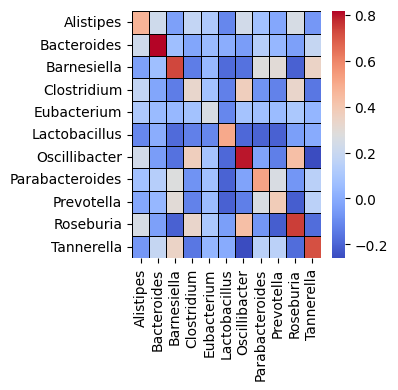

Mean inter genus:  0.02708475498497845
Mean intra genus:  0.5683634219824064


In [38]:
plt.figure(figsize=(4, 4))
sns.heatmap(mean_correlation, xticklabels = genera, yticklabels = genera, annot=False, cmap='coolwarm', linecolor = "black", linewidths=0.5, cbar=True)
plt.xticks(rotation=90)   # Rotate x-axis labels
plt.yticks(rotation=0)    # Rotate y-axis labels

plt.tight_layout()
plt.show()


plt.show()


mean_inter_genus = np.mean(mean_correlation[~np.eye(mean_correlation.shape[0], dtype=bool)])
mean_intra_genus = np.mean(np.diag(mean_correlation))

print("Mean inter genus: ", mean_inter_genus)
print("Mean intra genus: ", mean_intra_genus)

# Distances between z- normalized series

In [30]:
def genus_distance(genus_a, genus_b):
    filtered_species_a, num_species_a = species_list(genus_a)
    filtered_species_b, num_species_b = species_list(genus_b)
    print(genus_a, num_species_a, genus_b, num_species_b)
    if num_species_a < 1 or num_species_b <1:
        estimated_distance = None
        return estimated_distance
    estimated_distance = np.zeros(shape = (num_species_a, num_species_b))

    for i, s_a in enumerate(filtered_species_a):
        for j, s_b in enumerate(filtered_species_b):
            a = df[f"{s_a}"]
            b = df[f"{s_b}"]
            mask = ~np.isnan(a) & ~np.isnan(b)
            if np.sum(mask) > 1:
                a_normalized = ( a[mask] - np.mean(a[mask]) ) / np.std(a[mask])
                b_normalized = ( b[mask] - np.mean(b[mask]) ) / np.std(b[mask])
                print("")
                estimated_distance[i, j] = np.linalg.norm(a_normalized - b_normalized)
                #print(f"Estimated distance {s_a} {s_b} {estimated_distance[i, j]}")
            else:
                estimated_distance[i, j] = np.nan
    
    return estimated_distance
           

Prevotella 8 Prevotella 8


































































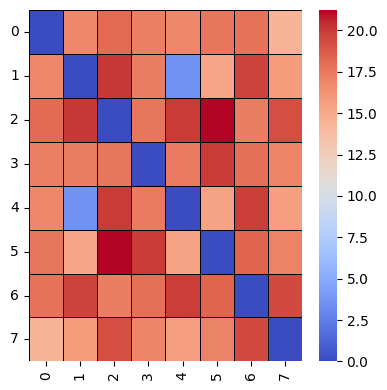

In [44]:
genus = "Prevotella"
distance_prevotella = genus_distance(genus, genus)
plt.figure(figsize=(4, 4))
sns.heatmap(distance_prevotella, annot=False, cmap='coolwarm', linecolor = "black", linewidths=0.5, cbar=True)
plt.xticks(rotation=90)   # Rotate x-axis labels
plt.yticks(rotation=0)    # Rotate y-axis labels
plt.tight_layout()
plt.show()

In [33]:
genera = populated_genera
mean_distance = np.zeros(shape = (len(genera), len(genera)))


from functools import lru_cache
@lru_cache(maxsize=None)
def cached_genus_distance(g1, g2):
    return genus_distance(g1, g2)


for i, genus_a in enumerate(genera):
    for j in range(i + 1, len(genera)):
        genus_b = genera[j]
        dist = cached_genus_distance(genus_a, genus_b)
        val = np.mean(dist) if corr is not None else np.nan
        mean_distance[i, j] = val
        mean_distance[j, i] = val  


for i, genus in enumerate(genera):
    dist = cached_genus_distance(genus, genus)
    val = np.mean(dist) if corr is not None else np.nan
    mean_distance[i, i] = val

Alistipes 3 Bacteroides 2






Alistipes 3 Barnesiella 2






Alistipes 3 Clostridium 24








































































Alistipes 3 Eubacterium 4












Alistipes 3 Lactobacillus 3









Alistipes 3 Oscillibacter 2






Alistipes 3 Parabacteroides 2






Alistipes 3 Prevotella 8
























Alistipes 3 Roseburia 2






Alistipes 3 Tannerella 2






Bacteroides 2 Barnesiella 2




Bacteroides 2 Clostridium 24
















































Bacteroides 2 Eubacterium 4








Bacteroides 2 Lactobacillus 3






Bacteroides 2 Oscillibacter 2




Bacteroides 2 Parabacteroides 2




Bacteroides 2 Prevotella 8
















Bacteroides 2 Roseburia 2




Bacteroides 2 Tannerella 2




Barnesiella 2 Clostridium 24
















































Barnesiella 2 Eubacterium 4








Barnesiella 2 Lactobacillus 3






Barnesiella 2 Oscillibacter 2




Barnesiella 2 Parabacteroides 2




Barnesie

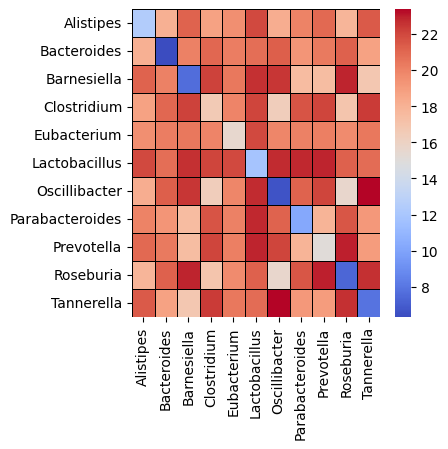

Mean inter genus:  20.4013286897955
Mean intra genus:  10.68671364741718


In [45]:
plt.figure(figsize=(4, 4))
sns.heatmap(mean_distance, annot=False,  xticklabels = genera, yticklabels = genera, cmap='coolwarm', linecolor = "black", linewidths=0.5, cbar=True)
plt.show()

mean_inter_genus = np.mean(mean_distance[~np.eye(mean_distance.shape[0], dtype=bool)])
mean_intra_genus = np.mean(np.diag(mean_distance))

print("Mean inter genus: ", mean_inter_genus)
print("Mean intra genus: ", mean_intra_genus)

## Plot for slides

In [2]:
mi.plot_species_NEW(subjects = [1, 2], save_fig = True, output_path = "new_outputs_miriam/ts_for_slides.png")

saved as new_outputs_miriam/ts_for_slides.png
